### A Deep Learning based Efficacy Prediction System for Drug Discovery

Here shows the demo for training process

In [1]:
########################################################
# All rights reserved. 
# Author: XIE Zhengwei @ Beijing Gigaceuticals Tech Co., Ltd 
#                      @ Peking University International Cancer Institute
# Contact: xiezhengwei@gmail.com
#
#
########################################################
import os
# import pdb
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# from densenet import DLEPS
from dleps_predictor2_playground_gvae_cnn import DLEPS
from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping

## Note: protobuf error can be resolved by downgrading it v3.20.1

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [2]:
# pdb.set_trace()
dleps_p = DLEPS()
model = dleps_p.model[0]
model.summary()

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 277, 76)      0                                            
__________________________________________________________________________________________________
visible_1 (InputLayer)          (None, 26, 1000)     0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 269, 9)       6165        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 26, 32)       96032       visible_1[0][0]                  
_____________

In [4]:
import h5py

h5f = h5py.File('../../data/vae_train.h5', 'r')
vae_train = h5f['data'][:]
h5f = h5py.File('../../data/vae_test.h5', 'r')
vae_test = h5f['data'][:]
h5f = h5py.File('../../data/gene_exp_data_train.h5', 'r')
seq_train = h5f['data'][:]
h5f = h5py.File('../../data/gene_exp_data_test.h5', 'r')
seq_test = h5f['data'][:]
h5f2 = h5py.File('../../data/y_train.h5', 'r')
y_train = h5f2['data'][:]
h5f2 = h5py.File('../../data/y_test.h5', 'r')
y_test = h5f2['data'][:]
# h5f3 = h5py.File('../../data/gene_exp_data_test.h5', 'r')
# seq_test = h5f3['data'][:]
# h5f4 = h5py.File('../../data/gene_exp_labels_test.h5', 'r')
# seq_labels = h5f4['data'][:]

print(vae_train.shape)
print(vae_test.shape)
print(seq_train.shape)
print(seq_test.shape)
print(y_train.shape)
print(y_test.shape)

(350, 277, 76)
(75, 277, 76)
(350, 978, 2)
(75, 978, 2)
(350,)
(75,)


## Leveraging transfer learning for pretrained models

In [5]:
# Freezing already trained layers
# for layers in model.layers[:-8]:
#     layers.trainable = False

In [6]:
# compile the model
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 

In [7]:
# Use ModelCheckpoint to save model and weights
from keras.callbacks import ModelCheckpoint
# filepath = "weights.best.sequential.hdf5" - best
# filepath = "weights.best.sample.hdf5"
filepath = "test.weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [8]:
# Use the final model to get a single output
epochs = 1000
batch_size = 50
early_stopping = EarlyStopping(monitor='val_mae', patience=10)
history = model.fit([seq_train, vae_train], y_train, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint, early_stopping], validation_data=([seq_test, vae_test], y_test))


Train on 350 samples, validate on 75 samples
Epoch 1/1000
350/350 [==============================] - 3s 7ms/step - loss: 0.1330 - mae: 0.2439 - val_loss: 0.2376 - val_mae: 0.3746

Epoch 00001: val_loss improved from inf to 0.23759, saving model to weights.best.sample.hdf5
Epoch 2/1000
350/350 [==============================] - 1s 3ms/step - loss: 0.0706 - mae: 0.1695 - val_loss: 0.1731 - val_mae: 0.3143

Epoch 00002: val_loss improved from 0.23759 to 0.17310, saving model to weights.best.sample.hdf5
Epoch 3/1000
350/350 [==============================] - 1s 3ms/step - loss: 0.0479 - mae: 0.1206 - val_loss: 0.1822 - val_mae: 0.3163

Epoch 00003: val_loss did not improve from 0.17310
Epoch 4/1000
350/350 [==============================] - 1s 3ms/step - loss: 0.0514 - mae: 0.1212 - val_loss: 0.1797 - val_mae: 0.3151

Epoch 00004: val_loss did not improve from 0.17310
Epoch 5/1000
350/350 [==============================] - 1s 3ms/step - loss: 0.0499 - mae: 0.1224 - val_loss: 0.1908 - val_

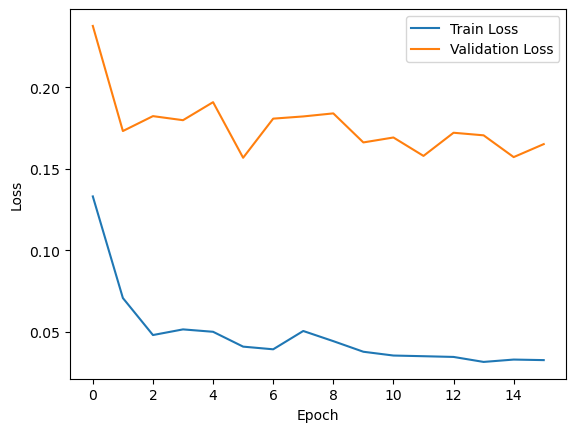

In [9]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

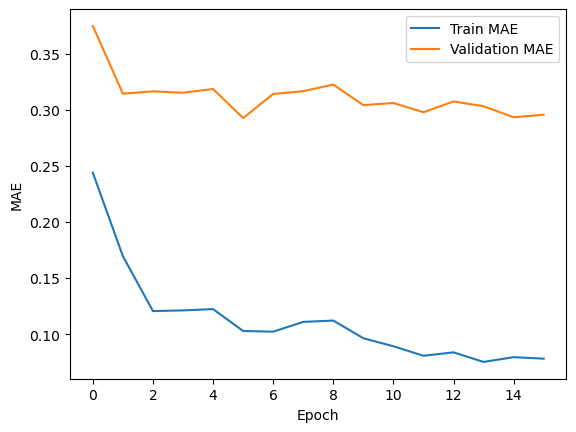

In [10]:
# Plot the training and validation MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [11]:
model.load_weights("weights.best.sample.hdf5")

In [12]:
# Find the epoch with the minimum validation loss
optimal_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1
print(f"Optimal Epoch: {optimal_epoch} loss: {history.history['val_loss'][optimal_epoch-1]}")

Optimal Epoch: 6 loss: 0.15669692556063333


In [13]:
# Evaluate the model on the test set
results = model.evaluate([seq_test, vae_test], y_test)

75/75 [==============================] - 0s 924us/step


In [14]:
# Print the evaluation results
print("Test Loss:", results[0])
print("Test MAE:", results[1])

Test Loss: 0.15681691338618597
Test MAE: 0.2926950454711914


[[1.         0.45624145]
 [0.45624145 1.        ]]
0.2052277302667943


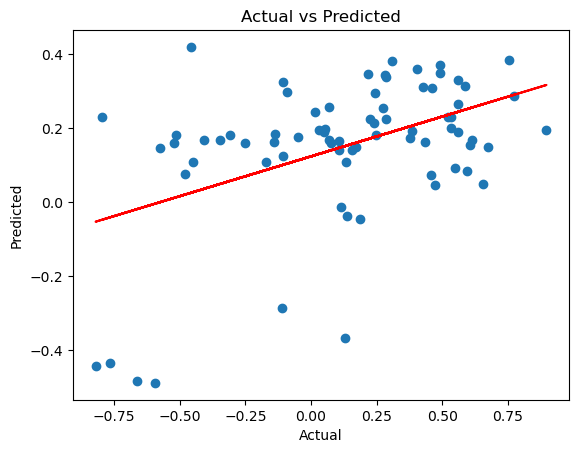

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
y_pred = model.predict([seq_test, vae_test])
print(np.corrcoef(y_test, y_pred.ravel()))
print(r2_score(y_test, y_pred))
plt.scatter(y_test, y_pred)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, 'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [16]:
sorted(y_pred)

[array([-0.48856765], dtype=float32),
 array([-0.48407763], dtype=float32),
 array([-0.44155127], dtype=float32),
 array([-0.43371114], dtype=float32),
 array([-0.36591083], dtype=float32),
 array([-0.28662047], dtype=float32),
 array([-0.04526453], dtype=float32),
 array([-0.03701085], dtype=float32),
 array([-0.0143947], dtype=float32),
 array([0.04581488], dtype=float32),
 array([0.04964653], dtype=float32),
 array([0.07389359], dtype=float32),
 array([0.07616952], dtype=float32),
 array([0.08347785], dtype=float32),
 array([0.09241144], dtype=float32),
 array([0.10739856], dtype=float32),
 array([0.10837049], dtype=float32),
 array([0.10859112], dtype=float32),
 array([0.12396609], dtype=float32),
 array([0.1404584], dtype=float32),
 array([0.14131795], dtype=float32),
 array([0.14654994], dtype=float32),
 array([0.14801787], dtype=float32),
 array([0.14809926], dtype=float32),
 array([0.1531701], dtype=float32),
 array([0.15885898], dtype=float32),
 array([0.15920147], dtype=float

In [17]:
# Save model
from joblib import dump, load
dump(dleps_p.model[0], 'model.joblib')

['model.joblib']

In [18]:
# Run the test set
model = load('model.joblib')
model

In [19]:
h5f_zinc = h5py.File('../../data/SMILES_zinc_fda.h5', 'r')
zinc_test = h5f_zinc['data'][:]
zinc_pred = model.predict(zinc_test)
zinc_pred

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., ...

In [ ]:
# Merge test results column to the test dataset
import pandas as pd
zinc_fda_test = pd.read_csv('../../data/fda_zinc.csv')
len(zinc_fda_test)

1615

In [ ]:
zinc_fda_test['results'] = zinc_pred
zinc_fda_test

ValueError: Length of values (1612) does not match length of index (1615)

In [ ]:
### End

In [ ]:
y_pred = dleps_p.model[0].predict(smile_train)
rna_train = np.reshape(rna_train, y_pred.shape)
print(rna_train.shape)
print(y_pred.shape)
corr = np.array([0.])
corr=np.hstack((corr,np.corrcoef(rna_train[0],y_pred[0])[0, 1]))
print(corr)


(1041, 1)
(1041, 1)
[ 0. nan]


c:\Anaconda3\envs\dleps\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Anaconda3\envs\dleps\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\Anaconda3\envs\dleps\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


(1041, 277, 76)
(1041, 1)


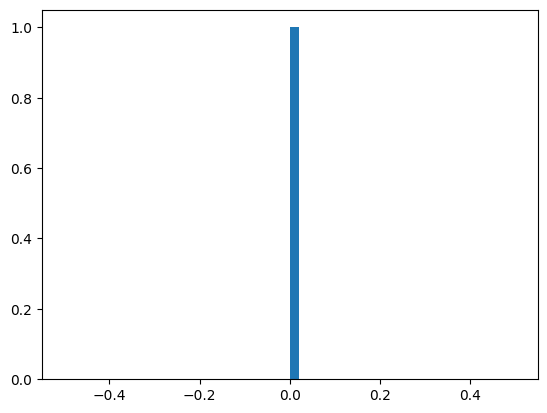

nan


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

y_pred = dleps_p.model[0].predict(smile_train)

corr = np.array([0.])

print(smile_train.shape)

print(y_pred.shape)
for i in range(smile_train.shape[0]):
    
    corr=np.hstack((corr,np.corrcoef(rna_train[i],y_pred[i])[0, 1]))
plt.hist(corr,50)
plt.show()
print(corr.mean())

In [ ]:
corr

array([ 0., nan, nan, ..., nan, nan, nan])

In [ ]:
from scipy.stats import gaussian_kde

def density(x,y):
    xy = np.vstack([x,y])
    return gaussian_kde(xy)(xy)

Training set

c:\Anaconda3\envs\dleps\lib\site-packages\scipy\stats\kde.py:565: RuntimeWarning: Degrees of freedom <= 0 for slice
  aweights=self.weights))
c:\Anaconda3\envs\dleps\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\Anaconda3\envs\dleps\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: array must not contain infs or NaNs

<Figure size 2000x600 with 0 Axes>

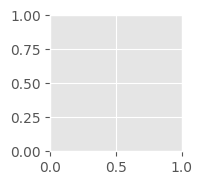

In [ ]:
n = 10  # how many digits we will display
sam = 50
plt.figure(figsize=(20, 6))

with plt.style.context(['ggplot']):
    plt.figure(figsize=(20, 6))
    for i in range(10):
        # display original
        ax = plt.subplot(3, n, i + 1)

        plt.scatter(y_pred[sam+i],rna_train[sam+i],c=density(y_pred[sam+i],rna_train[sam+i]),s=8,cmap=plt.get_cmap("coolwarm"))
        ax = plt.subplot(3, n, i + 1*10+1)

        plt.scatter(y_pred[sam+i+10],rna_train[sam+i+10],c=density(y_pred[sam+i+10],rna_train[sam+i+10]),s=8,cmap=plt.get_cmap("coolwarm"))
        ax = plt.subplot(3, n, i + 1*20+1)

        plt.scatter(y_pred[sam+i+20],rna_train[sam+i+20],c=density(y_pred[sam+i+20],rna_train[sam+i+20]),s=8,cmap=plt.get_cmap("coolwarm"))


plt.tight_layout()
#plt.savefig('../analysis_plot/Figures/Train_Samples3_density.svg', format='svg')

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Analysis of Testing set

(100, 277, 76)
(100, 1)


c:\Anaconda3\envs\dleps\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


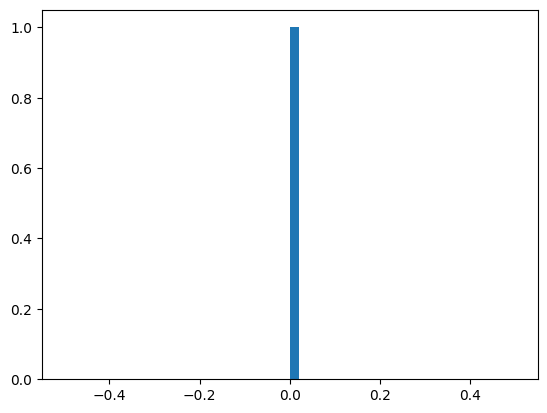

nan


In [ ]:
y_pred2 = dleps_p.model[0].predict(smile_test)

corr = np.array([0.])

print(smile_test.shape)

print(y_pred2.shape)
for i in range(smile_test.shape[0]):
    corr=np.hstack((corr,np.corrcoef(rna_test[i],y_pred2[i])[0, 1]))
plt.hist(corr,50)
plt.show()
print(corr.mean())

Testing set

In [ ]:
n = 10  # how many digits we will display
sam = 50
with plt.style.context(['science','no-latex']):
    plt.figure(figsize=(20, 6))
    for i in range(10):
        # display original
        ax = plt.subplot(3, n, i + 1)

        plt.scatter(y_pred2[sam+i],rna_test[sam+i],s=8,c=density(y_pred2[sam+i],rna_test[sam+i]),cmap="coolwarm")
        ax = plt.subplot(3, n, i + 1*10+1)

        plt.scatter(y_pred2[sam+i+10],rna_test[sam+i+10],c=density(y_pred2[sam+i+10],rna_test[sam+i+10]),s=8,cmap=plt.get_cmap("coolwarm"))
        ax = plt.subplot(3, n, i + 1*20+1)

        plt.scatter(y_pred2[sam+i+20],rna_test[sam+i+20],c=density(y_pred2[sam+i+20],rna_test[sam+i+20]),s=8,cmap=plt.get_cmap("coolwarm"))


plt.tight_layout()
#plt.savefig('../analysis_plot/Figures/Test_Samples3_density.svg', format='svg')

OSError: 'science' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles